<a href="https://colab.research.google.com/github/ethanmarshallanalytics/Deep-Learning-and-Neural-Networks/blob/main/MATH_6373_Homework_5_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem 1

In [6]:
alexnet_model = models.alexnet(pretrained=True)
print(alexnet_model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

## Problem 2

In [7]:
import torch
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import os
from tqdm import tqdm
from PIL import Image
import numpy as np
import pandas as pd
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.models as models

from google.colab import drive

drive.mount('/content/drive/')
# Define transforms for the training data and testing data
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Function to load dataset with unique labels for each class
def load_dataset(folder_path, preprocess):
    data = []
    label = 0

    for subfolder in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, subfolder)
        print(subfolder_path)
        if os.path.isdir(subfolder_path):
            for image_file in tqdm(os.listdir(subfolder_path)):
                image_path = os.path.join(subfolder_path, image_file)
                if os.path.isfile(image_path):  # Ensure we're dealing with a file, not a directory
                    print(image_path)
                    image = preprocess(Image.open(image_path))
                    data.append((image, label))
            label += 1  # Increment label for each subfolder
            print(label)
    return data

# Load the Cats breed dataset using the new approach
folder_path = '/content/drive/MyDrive/cats-breed-dataset/cat_v1'
dataset = load_dataset(folder_path, preprocess)


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/cats-breed-dataset/cat_v1/maine_coon


  0%|          | 0/2 [00:00<?, ?it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/maine_coon/154d0dfcc8a953dc2adea273e02c0cb2.jpg


 50%|█████     | 1/2 [00:00<00:00,  3.89it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/maine_coon/098d3da3d30a35356744d87c57af4280.jpg


100%|██████████| 2/2 [00:00<00:00,  3.55it/s]


1
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal


  0%|          | 0/174 [00:00<?, ?it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/04413-Bengal-cat-white-background.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/09a0c5d574f818471c84cf509fc786dc.jpg


  2%|▏         | 3/174 [00:01<01:29,  1.91it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/047ffa2f7165ccc4585e418ddb800299.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/00438-Bengal-cat-snarling.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/00e79f939696ea0c095603154c4af840.jpg


  4%|▍         | 7/174 [00:02<00:36,  4.55it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/05050-Brown-spotted-Bengal-cat-sitting-on-grey-background.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/03915-Pair-of-Bengal-kittens-white-background.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/00441-Very-timid-Brown-Spotted-Bengal-cat-ears-back.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/1e8351aa322b32f7a23980d7cdbed1a8.jpg


  5%|▌         | 9/174 [00:02<00:31,  5.29it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/32249-Bengal-female-cat-white-background.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/12651963_f520.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/306059656_c4fafc4a87_o.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/2308642374_57489bb2ce_o-57b742c15f9b58cdfdb97b03.jpg


 10%|▉         | 17/174 [00:02<00:14, 10.97it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/14105889_f520.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/28430549_572162953143506_2215371262585208832_n-5a96060b1f4e1300367ff4f0.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/15658-Brown-spotted-Bengal-female-cat.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/122433177_3649288731759742_6202950879910256561_o.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/15a0a84bd11fcae601ed41f5672191ba.jpg


 11%|█         | 19/174 [00:03<00:16,  9.30it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/0c87060cea587a01f0a254066c95deaa.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/2385251605b4059a955e526.09727891-profile-1422.jpg


 12%|█▏        | 21/174 [00:03<00:14, 10.74it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/22384097_10154807489365927_7732210437813358666_o.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/28209b6d36d53298996458299227dca4.png
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/1b2a68f85a32410fb3fd776927a2f4ef.jpg


 13%|█▎        | 23/174 [00:03<00:15, 10.04it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/1142194.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/1111246.jpg


 14%|█▍        | 25/174 [00:04<00:20,  7.41it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/1113154.jpg


 16%|█▌        | 27/174 [00:04<00:22,  6.45it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/20121130172827.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/1096165.jpg


 18%|█▊        | 31/174 [00:04<00:18,  7.60it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/119mokiL1.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/1200px-Bangie_the_Bengal_Cat.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/106f59608bc9fc6ac11df31008efdf94.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/1aeae43be56c47450ef4a3354d3e940d.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/28157986_217164348841297_8045674480825008128_n-5a9606581f4e1300367fff3f.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/677597.jpg


 21%|██        | 36/174 [00:06<00:24,  5.62it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/6e3f4bd0cac61152e1e3addadd2f8b99.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/68a0ecf22205aca18f080c83a32e083e.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/67dd59a71ac467ca3224dd3ce87b1a6e.jpg


 21%|██▏       | 37/174 [00:06<00:27,  5.01it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/379800.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/3931eb090308eeaa58719fe66b9926c3.jpg


 22%|██▏       | 39/174 [00:06<00:23,  5.80it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/3eb7e9a7542bdead2c633e4a2b06a588.jpg


 23%|██▎       | 40/174 [00:07<00:26,  4.99it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/60a954c22bba1.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/40706-Portrait-of-Bengal-cat.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/687362.jpg


 25%|██▍       | 43/174 [00:07<00:19,  6.65it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/5fba2bc61c502d3177e845b48807e38d.jpg


 27%|██▋       | 47/174 [00:07<00:17,  7.07it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/6ae66c9e98081d48648b8ecc9784aedf.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/610850dbd28f3cfea67e7d6350a8a0c1.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/7333956_f120.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/3be35b792cbaa987776772fd2a67b78e.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/53653d0ade9fc4d625055cd5c45b8d5c.jpg


 29%|██▊       | 50/174 [00:09<00:27,  4.58it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/789944-best-bengal-cat-wallpaper-2880x1800-download-free.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/425c7c6eba0b92a7da8d32e4502ff0e5.jpg


 30%|███       | 53/174 [00:09<00:19,  6.17it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/40725-Bengal-cat-sitting-white-background.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/42cfe991ab15fe999d446660b4ccb0b8.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/7705350_f496.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/AdobeStock_201128593.jpg


 33%|███▎      | 57/174 [00:09<00:13,  8.73it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/Bengal7-1.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/8f85e72ba3af0bab8acfaafa6b84b64e.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/92e7c0330b327268daedd9bef9e24b32.2.Snow-Bengal-Cats.jpg


 34%|███▍      | 59/174 [00:09<00:12,  9.44it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/Bengal-Cat-Blog-Photo-12122901.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/81cfdf3adf43735cfb1ff26f4a39eb37.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/Available-Kitten.jpg


 36%|███▌      | 63/174 [00:10<00:10, 10.51it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/Bengal-Cat-Blog-Photo-003.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/Bengal9.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/Bengal-Cat-Blog-Photo-13022501.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/896b6fec2b1cfe35ca5e756f03832b92.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/82ae5d_88846557182b414c9f209e38a5e1fdca.jpg


 39%|███▉      | 68/174 [00:10<00:11,  9.34it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/A11--scaled.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/8eb8f42f1120b1e839a80b30d46398d1.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/7ef579c35092abb4e947cc5f14cd10e0.jpg


 41%|████▏     | 72/174 [00:11<00:08, 11.82it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/Beautiful-Bengal-Cat-Playing.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/86.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/999b15a314def9fed80ae19e4f1274f9.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/8419356703_be58f9befa_b.jpg


 43%|████▎     | 75/174 [00:11<00:07, 13.52it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/Bengal-Cat-Loves-To-Play.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/Bengal-cat (2).jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/Bengal-Cat-Blog-Photo-12080404.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/A1kDTTc.jpg


 44%|████▍     | 77/174 [00:11<00:08, 11.40it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/84820126f5b8ca529e642f1f05e1f16a.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/Bengal_cat_2.jpg


 47%|████▋     | 81/174 [00:11<00:08, 11.25it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/Canva-Bengal-cat-Portrait.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/Photo3-1-1024x1024.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/IMG_9518.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/My-little-dude-apollo-the-bengal-cat.jpg


 49%|████▉     | 85/174 [00:12<00:06, 12.82it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/Fantastic-Bengal-Cat-With-Green-Eyes.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/TgqzRs.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/Cutest-Bengal-Cat-Have-Gorgeous-Blue-Eyes.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/GettyImages-140000553-5bd2454846e0fb0051a52178.jpg


 52%|█████▏    | 91/174 [00:12<00:04, 18.38it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/Bengal_Cat.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/Brilliant-Brown-Bengal-Cat-Looking-Up.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/Mind-Blowing-Bengal-Cat-Mother-With-Their-Small-Kids.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/Full-Grown-Adult-Bengal-Cat-Sitting-On-Floor.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/Seal-Lynx-Point.jpg


 54%|█████▍    | 94/174 [00:12<00:04, 19.45it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/Big-Bengal-Cat-Is-Very-Lazy.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/Golden-And-Black-Bengal-Cat-In-Womans-Arm.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/IMG_9526.jpg


 56%|█████▌    | 97/174 [00:12<00:05, 12.95it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/Cat-L00131926-euscNM-orig.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/Small-Bengal-Cat-Kitten-With-Tiny-Tail.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/QkzHIH8.jpg


 57%|█████▋    | 99/174 [00:13<00:05, 14.07it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/Gato-bengal-grandes-factos-que-desconhece.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/b17.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/Thor-Belgian-Bengal-Cat.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/amur-leopard-cub-bengal-cat-photography-wallpaper.jpg


 60%|█████▉    | 104/174 [00:13<00:07,  9.97it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/beigeboy2frontlg5wks.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/b9d81405fffd73fdd76b81cc3765ae2c.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/a3affb33a4ae8e429f0874b01dd7b0d1.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/Very-Lazy-Bengal-Cat-Have-Green-Eyes.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/bengal-556672.jpg


 64%|██████▍   | 111/174 [00:14<00:04, 15.44it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/ba38842b26fb69a89f7cbab2e89b3302.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/ab5af54db4045d1bca31bc4a8bd29911.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/bengal-534185.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/babbling-bengals.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/WwOtFWJ.jpg


 65%|██████▍   | 113/174 [00:14<00:03, 16.27it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/b11acb20797de687a98396435c9ec0ee.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/Two_bengal_cats_edit.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/bengal-cat-sitting-on-garden-table-1334048.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/bengal-cat9.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/bengal-esa-cat-mango-clinic.jpg


 70%|██████▉   | 121/174 [00:15<00:05,  9.82it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/bengal-cat (1).jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/bengal-cat-looking-back-1335152.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/bengal-cat-1331937.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/bengal-cat_sm.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/bengal-582741.jpeg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/bengal-cat-1337628.jpg


 74%|███████▎  | 128/174 [00:15<00:02, 15.62it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/bengal-kitten-860995.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/bengal-cat-on-blanket-1331931.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/bengal-cat-breed.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/bengal-cat-running-in-snow-1336009.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/bengal-cat-in-funny-position-1335167.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/bengal-cat.jpg


 75%|███████▌  | 131/174 [00:15<00:03, 13.91it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/bengal-cat-9.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/bengal-cat-not-a-pet-for-everyone.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/cool-bengal-cat-names.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/bengal-kitten-9.jpg


 79%|███████▊  | 137/174 [00:16<00:02, 13.22it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/cute-bengal-cat-names.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/bengal_2042592_1920.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/bengal291-1.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/g_snow_7.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/ebe4dba7f07ec3734ec73da194467701.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/d30490cd8cffc4faa8f9c5c55e633529.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/f8fcdf63b055734d2348055e4efeccf9.jpg


 82%|████████▏ | 142/174 [00:16<00:02, 12.79it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/bengal_cat_stock_20140324_1_by_furlined-d7kmoef.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/i6yb8bicghp31.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/fullsizeoutput_4f30.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/bengalcat-56a2bcd95f9b58b7d0cdf798.jpg


 84%|████████▍ | 146/174 [00:17<00:02, 13.41it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/image.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/fullsizeoutput_63d4.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/bild-20140514210810.jpg


 85%|████████▌ | 148/174 [00:17<00:01, 14.53it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/imageOriginal.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/fullsizeoutput_6412.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/dce7879e1be9d6fb1098e3a2517a5ba8.jpg


 86%|████████▌ | 150/174 [00:17<00:01, 14.03it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/image2_8-2.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/image1_3-3.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/e4abdc9e6db9fdfce4d92cd576eda658.jpg


 89%|████████▉ | 155/174 [00:17<00:01, 13.70it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/featured-bengal-cat-price.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/cute-bengal-cat-2560x1600-wide-wallpapers.net.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/boy-bengal-cat-names.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/image3_2-1.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/fullsizeoutput_63f0.jpg


 92%|█████████▏| 160/174 [00:17<00:00, 14.24it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/img_9728.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/xhl9l24plbw01.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/nebss.jpg


 94%|█████████▎| 163/174 [00:18<00:00, 16.35it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/kan-143-scaled.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/silver-bengal-cat-names.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/thumb-1920-1033849.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/wp2495202.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/zdh28okbkl311.jpg


 95%|█████████▌| 166/174 [00:18<00:00, 15.33it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/wp4247085.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/pexels-photo-326971.jpeg


 97%|█████████▋| 168/174 [00:18<00:00, 12.51it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/wp4247071.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/lounging_bengal_cat_stock_20130804_1_by_furlined-d6gn2pf.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/silver-spotted-bengal.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/pexels-photo-977955.jpeg


100%|██████████| 174/174 [00:19<00:00,  9.14it/s]


/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/img_9451.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/bengal/maxresdefault-60.jpg
2
/content/drive/MyDrive/cats-breed-dataset/cat_v1/ragdoll


0it [00:00, ?it/s]


3
/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair


  0%|          | 0/119 [00:00<?, ?it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/1200px-American_Shorthair.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/0C40F888-7B22-4B2C-88B5-049BBB40E374.jpeg


  2%|▏         | 2/119 [00:00<00:24,  4.73it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/10bc40c87f24b7442f454f90f1248e16.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/1200x0 (1).jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/04f2e5e2f67443c7c3299ce4078dc2a2.jpg


  4%|▍         | 5/119 [00:00<00:13,  8.61it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/0cd53884802ed1f687f6ddb860973b8b.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/1200px-Cat03.jpg


  8%|▊         | 10/119 [00:00<00:08, 12.65it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/046dce16530c0e2f62348adc724dbc4b.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/1200-93358197-domestic-shorthair-cats-playing.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/404469246.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/20180808_221155.jpg


 10%|█         | 12/119 [00:01<00:09, 11.49it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/438649_28986_orig.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/189edc1cdd4d2ad45352e6d5a05ebdf2.jpg


 13%|█▎        | 16/119 [00:01<00:08, 11.94it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/232069151.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/1286px-British_Shorthair_Cat.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/20-02-2020RG-3-scaled.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/228794488.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/20171217_153823.jpg


 17%|█▋        | 20/119 [00:02<00:10,  9.58it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/37087816_10216998859910320_332375493129011200_n.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/210084761.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/242111_e8cda_orig.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/1200x0 (2).jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/19c64d2430d89fb1d0b21f3037b52431.jpg


 19%|█▉        | 23/119 [00:02<00:08, 11.96it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/17e3677e829dc216edcc4c1982680495.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/388271506.jpg


 21%|██        | 25/119 [00:02<00:08, 11.04it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/31f7662ca0182a2ef145e580745a1a01.jpg


 25%|██▌       | 30/119 [00:02<00:06, 12.77it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/1200x0.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/1200x0 (3).jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/1280-594481594-little-kitten-scaled.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/1585003597_2615038995e793c4deb2bb.jpeg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/204646681.jpg


 29%|██▉       | 35/119 [00:03<00:05, 15.60it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/13299451414_6217c5c653_b.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/19072-British-Shorthair-tabby-tortoiseshell-cat-reclining-white-background.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/204574584.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/543426094.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/502158847.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/504925860.jpg


 31%|███       | 37/119 [00:03<00:05, 15.99it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/50f20a3651b0742f2eb623a5c011a653.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/509787583.jpg


 34%|███▍      | 41/119 [00:03<00:06, 11.56it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/482497577.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/508396792.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/546250_9f2e0_orig.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/499844134.jpg


 36%|███▌      | 43/119 [00:03<00:05, 13.06it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/466748758.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/523771009.jpg


 38%|███▊      | 45/119 [00:04<00:06, 10.82it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/501189109.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/461138744.jpg


 39%|███▉      | 47/119 [00:04<00:07, 10.14it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/536180_dd3d3_orig.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/7e06a124cfc5c08e0492fbf13482d889.jpg


 41%|████      | 49/119 [00:04<00:07,  9.72it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/5bdf4ba6-184b-4559-88e3-8cabc3b9d89a_5.a15ed7d25a297e1bf4776d6d5691a422.jpeg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/92fdf4d2bce3e0f8163176c73bf75530.jpg


 43%|████▎     | 51/119 [00:05<00:10,  6.57it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/7d23228181d836896c1f89edbb4d0b9b.jpg


 45%|████▍     | 53/119 [00:05<00:12,  5.45it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/Cat-F00105530-hNOj8z-orig.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/American-Shorthair-Cat-2-1250x834.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/5bec89c5926a1.image.jpg


 47%|████▋     | 56/119 [00:05<00:07,  8.33it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/5ca4f9dbdfb21.image.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/964b1ff9b318408f68efe6723ae57c71.jpg


 49%|████▊     | 58/119 [00:06<00:09,  6.54it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/Cat-F00105530-gN0g9c-orig.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/8ccba5e8af1d6d4531cc291294e785bd.jpg


 50%|████▉     | 59/119 [00:06<00:11,  5.38it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/Bandit.jpg


 52%|█████▏    | 62/119 [00:07<00:09,  6.00it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/AdobeStock_215272137-scaled.jpeg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/760496255ddc34fd12e534ecae9a41cd.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/981ae64c456d497730bd9475cb75aff7.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/British-Shorthair-cat-WW-66384233.jpeg


 55%|█████▍    | 65/119 [00:08<00:15,  3.58it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/American-shorthair-cat.jpeg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/86 (1).jpg


 59%|█████▉    | 70/119 [00:08<00:06,  7.46it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/BlueBritishShorthairwithGoldEyes-4734bd8247b04451b6da1994a3f62ae7.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/86.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/American-Shorthair-Kitten.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/983623a89687bc5524dab97c8642ef36.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/7cf57fb9a75ee67d966455888f34ac42.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/IMG_0947.jpeg


 61%|██████    | 72/119 [00:09<00:07,  6.00it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/DSCN0731.jpg


 62%|██████▏   | 74/119 [00:09<00:08,  5.27it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/Cat-L00095555-rUFAGS-orig.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/DSC_0007.jpg


 65%|██████▍   | 77/119 [00:10<00:07,  5.45it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/Cat-L00124263-KpBwNb-orig.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/Cat-F00116810-D1ZJSK-orig.jpeg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/Cat-L00123734-DnvT32-orig.jpeg


 66%|██████▋   | 79/119 [00:10<00:06,  6.36it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/Cat-F00116574-TIcURh-orig.jpeg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/Dom.jpg


 68%|██████▊   | 81/119 [00:10<00:06,  5.71it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/European_shorthair_cat_portrait.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/Domestic_shorthaired_cat_face.jpg


 70%|██████▉   | 83/119 [00:11<00:05,  6.11it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/Cat-L00138006-pEEYkC-orig.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/cat-British-Shorthair-grey.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/black-american-shorthair-cat.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/TuxedoCatonChair4722x4722-5797c5625f9b58461f449b90.jpg


 72%|███████▏  | 86/119 [00:11<00:04,  7.59it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/american-shorthair-cat.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/IMG_20180404_193304.jpg


 76%|███████▋  | 91/119 [00:11<00:02, 10.83it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/american-shorthair-cat-856159.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/ce851dbb5413afff9904a66a038d699d.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/british-shorthair-cat-696525.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/ash-e1584544879221.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/british-shorthair-673621.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/awruyaegsiweb0baasbs.jpg


 79%|███████▉  | 94/119 [00:11<00:01, 13.15it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/british-shorthair-660445.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/Lizzie-1.jpg


 83%|████████▎ | 99/119 [00:12<00:01, 13.52it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/british_shorthair_cute_cat.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/c8706a9f05a2f298bac780a407d472ef.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/ancestor-Burmese-cat-Wong-Mau-Siamese.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/animal-cat-domestic-shorthair-grey-indoors-pet-studio-tongue-tongue-M7107H.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/british-shorthair-cats-860953.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/britkittens2.jpeg


 86%|████████▌ | 102/119 [00:12<00:01, 16.52it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/black-american-shorthair-kittens.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/british-shorthair-cat_bGlqZ2eUmZqaraWkpJRrZWVlrWllZWU.jpg


 88%|████████▊ | 105/119 [00:13<00:01,  8.32it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/cat-3395720_1280.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/b590b2ed84ff824dd6276fe56b901c13.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/a-tortoiseshell-domestic-shorthair-cat-in-a-crouched-position-looking-directly-at-the-camera-RPT7JN.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/f4kwkfitruxcw9cqjlu7.jpg


 91%|█████████ | 108/119 [00:13<00:01,  8.83it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/df960998fbe63ab49ea80fc80242372e.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/meg.jpg


 92%|█████████▏| 110/119 [00:13<00:01,  6.36it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/oe91gie7tc1i0dvgkbkq.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/kqzbmulwse3w436pzmgv.jpg


 94%|█████████▍| 112/119 [00:14<00:01,  6.95it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/hollycat.jpg


 96%|█████████▌| 114/119 [00:14<00:00,  5.96it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/qfzck00hlbslqogdurzq.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/holly-cat.jpeg


 97%|█████████▋| 116/119 [00:14<00:00,  6.36it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/pyr675owieobbtw1ytbw.jpg
/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/gook5j9guzuuqu26ddve.jpg


 98%|█████████▊| 117/119 [00:15<00:00,  5.72it/s]

/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/monty-cat2.jpg


100%|██████████| 119/119 [00:15<00:00,  7.60it/s]


/content/drive/MyDrive/cats-breed-dataset/cat_v1/domestic_shorthair/th27x4eth09fh85rrdh5.jpg
4
/content/drive/MyDrive/cats-breed-dataset/cat_v1/siamese


0it [00:00, ?it/s]

5


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 1/5: Train Loss: 0.7860, Test Loss: 1.0377, Test Accuracy: 0.9322
Epoch 2/5: Train Loss: 0.4112, Test Loss: 1.3207, Test Accuracy: 0.9661
Epoch 3/5: Train Loss: 0.2685, Test Loss: 1.6091, Test Accuracy: 0.9153
Epoch 4/5: Train Loss: 0.5895, Test Loss: 1.6773, Test Accuracy: 0.8983
Epoch 5/5: Train Loss: 0.3221, Test Loss: 1.3781, Test Accuracy: 0.9153


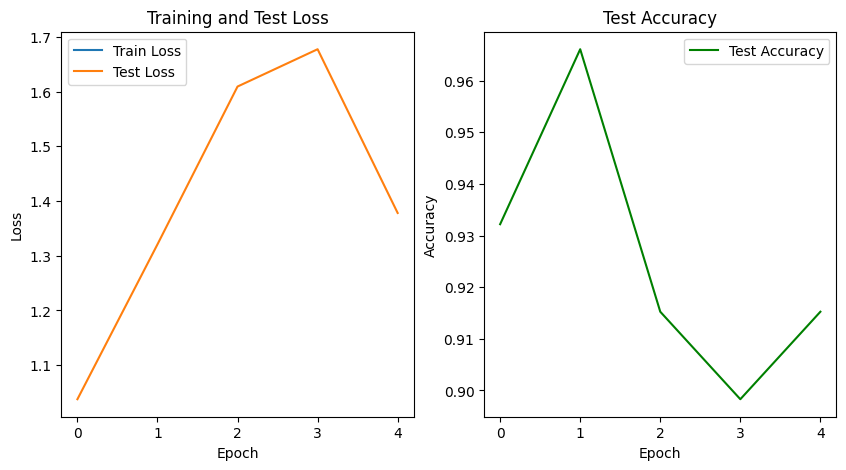

In [8]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=64)

model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)

# Freeze all layers except the last classifier layer
for param in model.parameters():
    param.requires_grad = False

# Modify the last fully connected layer
num_classes = 5
classifier_input_size = model.classifier[6].in_features
classifier = nn.Sequential(
    nn.Linear(classifier_input_size, 4096),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(4096, num_classes)
)
model.classifier[6] = classifier

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

epochs = 5
train_losses = []
test_losses = []
accuracies = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    train_loss = 0.0
    total_samples = 0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()* inputs.size(0)
        total_samples += labels.size(0)

    train_loss = running_loss / total_samples
    # Validation
    model.eval()
    test_loss = 0.0
    accuracy = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            batch_loss = criterion(outputs, labels)
            test_loss += batch_loss.item() * inputs.size(0)  # Accumulate the loss
            _, predicted = torch.max(outputs, 1)
            accuracy += torch.sum(predicted == labels).item()
            total_samples += labels.size(0)

    test_loss = test_loss / total_samples
    accuracy = accuracy / total_samples
    test_losses.append(test_loss)
    accuracies.append(accuracy)

    print(f"Epoch {epoch+1}/{epochs}: "
          f"Train Loss: {train_loss:.4f}, "
          f"Test Loss: {test_loss:.4f}, "
          f"Test Accuracy: {accuracy:.4f}")

    model.train()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Test Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')
plt.legend()
plt.show()



Problem 3

Epoch 1/5: Train Loss: 1.5889, Test Loss: 1.3892, Test Accuracy: 0.4576
Epoch 2/5: Train Loss: 1.3424, Test Loss: 1.0843, Test Accuracy: 0.4576
Epoch 3/5: Train Loss: 1.0802, Test Loss: 0.7768, Test Accuracy: 0.4576
Epoch 4/5: Train Loss: 0.8256, Test Loss: 0.7078, Test Accuracy: 0.5424
Epoch 5/5: Train Loss: 0.7208, Test Loss: 0.7048, Test Accuracy: 0.5424


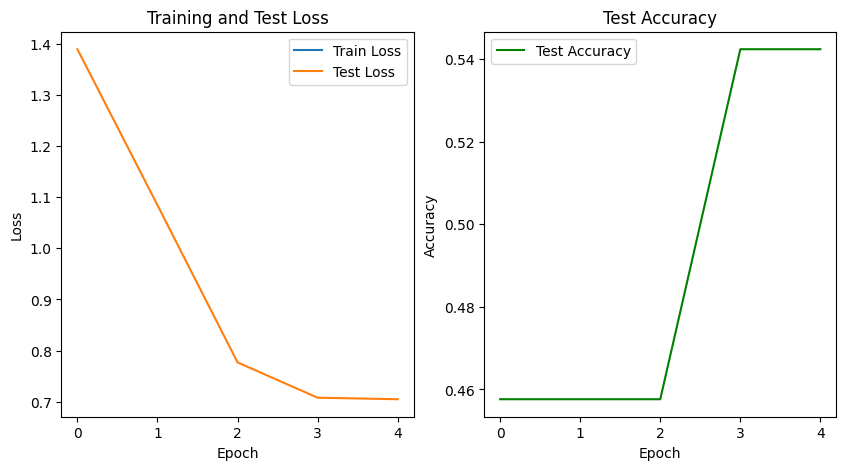

In [10]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=64)

model = models.alexnet(pretrained=False)  # Load AlexNet with random weights

# Modify the last fully connected layer
num_classes = 5
classifier_input_size = model.classifier[6].in_features
classifier = nn.Sequential(
    nn.Linear(classifier_input_size, 4096),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(4096, num_classes)
)
model.classifier[6] = classifier

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 5
train_losses = []
test_losses = []
accuracies = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    train_loss = 0.0
    total_samples = 0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()* inputs.size(0)
        total_samples += labels.size(0)

    train_loss = running_loss / total_samples
    # Validation
    model.eval()
    test_loss = 0.0
    accuracy = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            batch_loss = criterion(outputs, labels)
            test_loss += batch_loss.item() * inputs.size(0)  # Accumulate the loss
            _, predicted = torch.max(outputs, 1)
            accuracy += torch.sum(predicted == labels).item()
            total_samples += labels.size(0)

    test_loss = test_loss / total_samples
    accuracy = accuracy / total_samples
    test_losses.append(test_loss)
    accuracies.append(accuracy)

    print(f"Epoch {epoch+1}/{epochs}: "
          f"Train Loss: {train_loss:.4f}, "
          f"Test Loss: {test_loss:.4f}, "
          f"Test Accuracy: {accuracy:.4f}")

    model.train()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Test Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')
plt.legend()
plt.show()